## Machine Learning 

    K.B.S.Karunarathna

## Customer Churn Prediction System

### Problem Definition

Develop a machine learning algorithm to accurately predict customer churn rate for an Iranian telecom company

### Import Required Libraries 

In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor

### Data Collection

In [371]:
path = "C:/Users/acer/OneDrive - University of Moratuwa/iranian+churn+dataset/Customer Churn.csv"
df = pd.read_csv(path)
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21,0,19,2,6697,147,92,44,2,2,1,25,721.980,0
3146,17,0,17,1,9237,177,80,42,5,1,1,55,261.210,0
3147,13,0,18,4,3157,51,38,21,3,1,1,30,280.320,0
3148,7,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0


In [372]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Call  Failure            3150 non-null   int64  
 1   Complains                3150 non-null   int64  
 2   Subscription  Length     3150 non-null   int64  
 3   Charge  Amount           3150 non-null   int64  
 4   Seconds of Use           3150 non-null   int64  
 5   Frequency of use         3150 non-null   int64  
 6   Frequency of SMS         3150 non-null   int64  
 7   Distinct Called Numbers  3150 non-null   int64  
 8   Age Group                3150 non-null   int64  
 9   Tariff Plan              3150 non-null   int64  
 10  Status                   3150 non-null   int64  
 11  Age                      3150 non-null   int64  
 12  Customer Value           3150 non-null   float64
 13  Churn                    3150 non-null   int64  
dtypes: float64(1), int64(13)

The dataset consists of 3150 rows, each representing a unique customer, with 13 features such as call failures, complaints, subscription length, charge amount, seconds of use, frequency of use, frequency of SMS, distinct called numbers, age group, tariff plan, status, age, and customer value. 

'Churn' is the target variable for the prediction model. 

### Exploratory Data Analysis (EDA)

#### Visualize features and their distributions

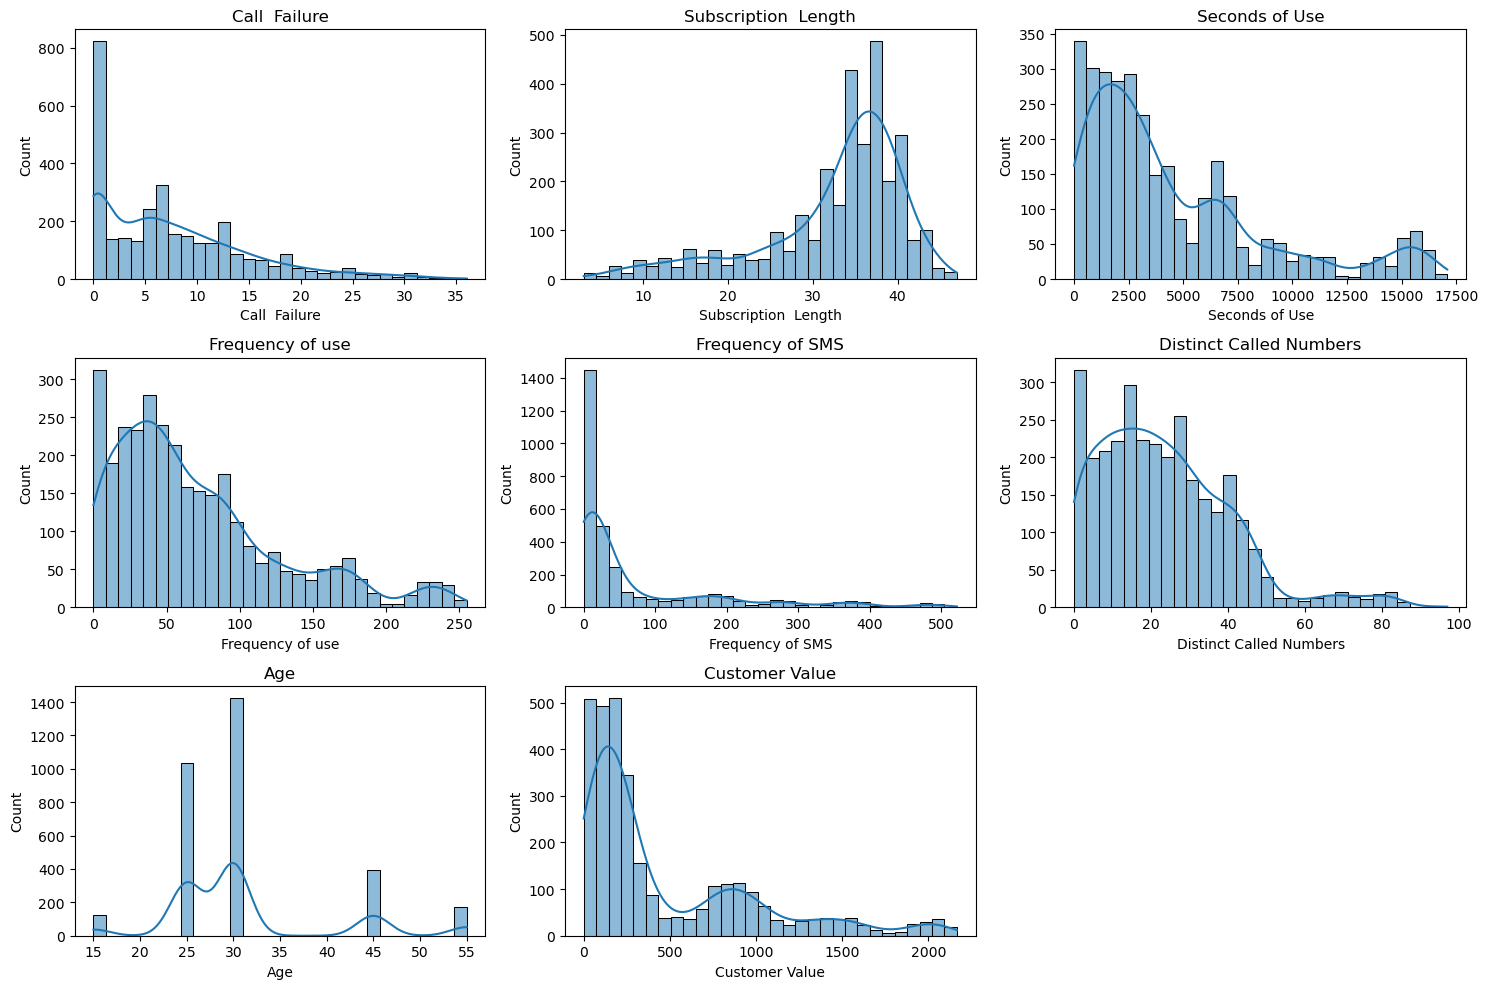

In [373]:
# Plot histograms for numerical features
num_features = ['Call  Failure', 'Subscription  Length', 'Seconds of Use',
                'Frequency of use', 'Frequency of SMS', 'Distinct Called Numbers', 'Age', 'Customer Value']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, edgecolor='k')
    plt.title(feature)
plt.tight_layout()
plt.show()

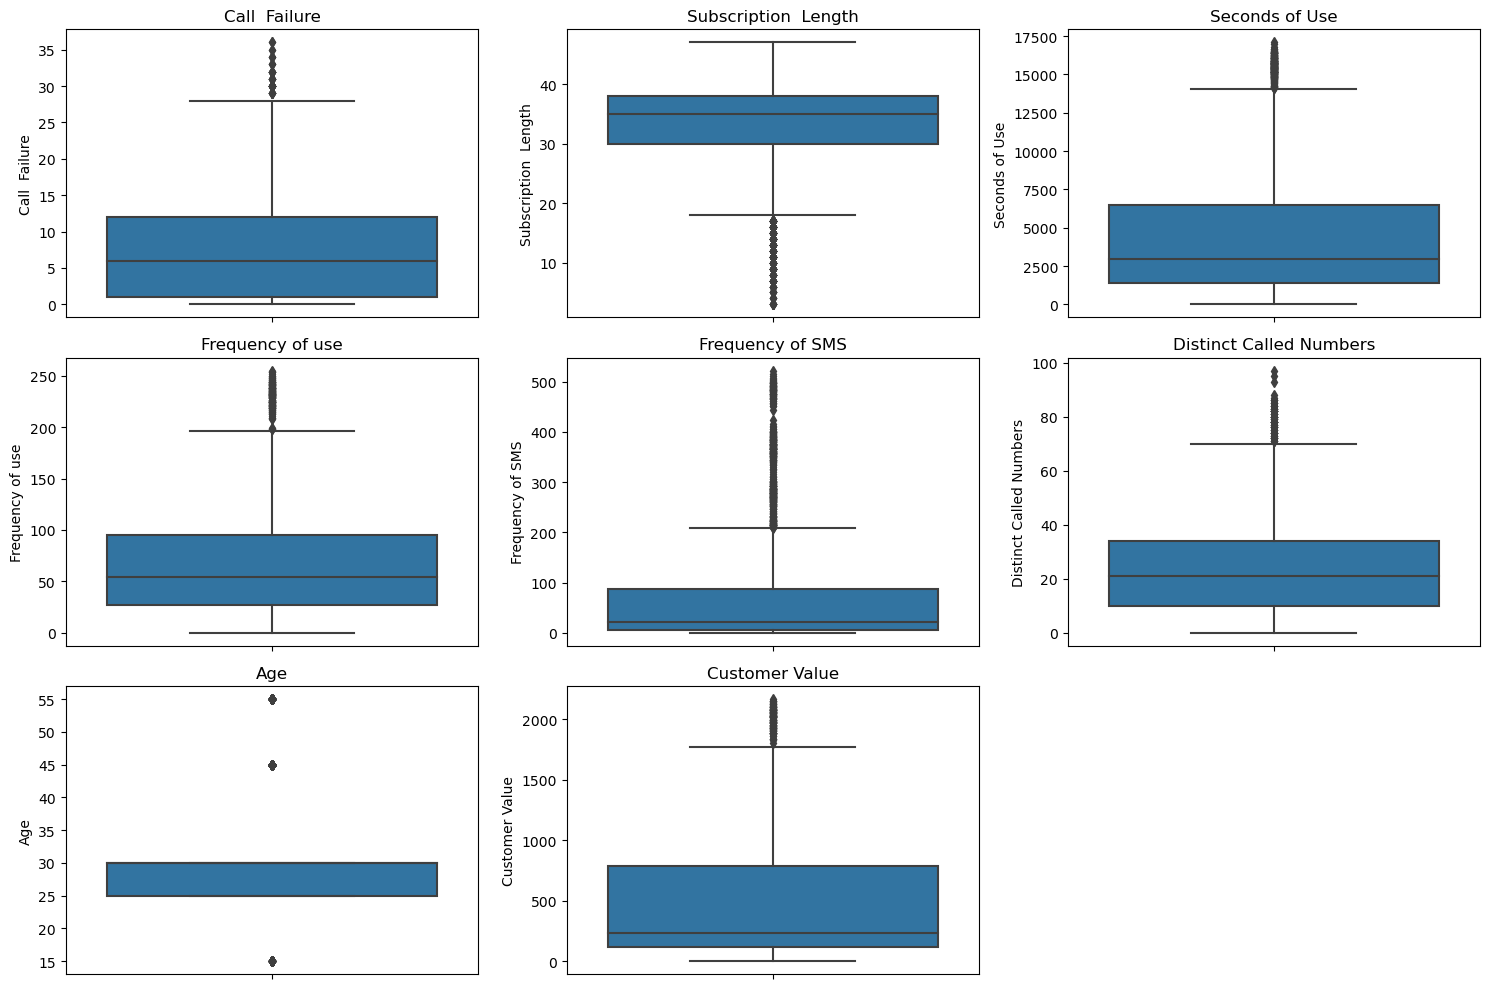

In [374]:
# Box plots to visualize distributions and outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

It indicates that there are extreme values in features. In the context of predicting customer churn, these outliers could indeed be valuable as they may correspond to extreme usage patterns or customer behaviors that are important for the model to capture. Hence, outliers were not removed.

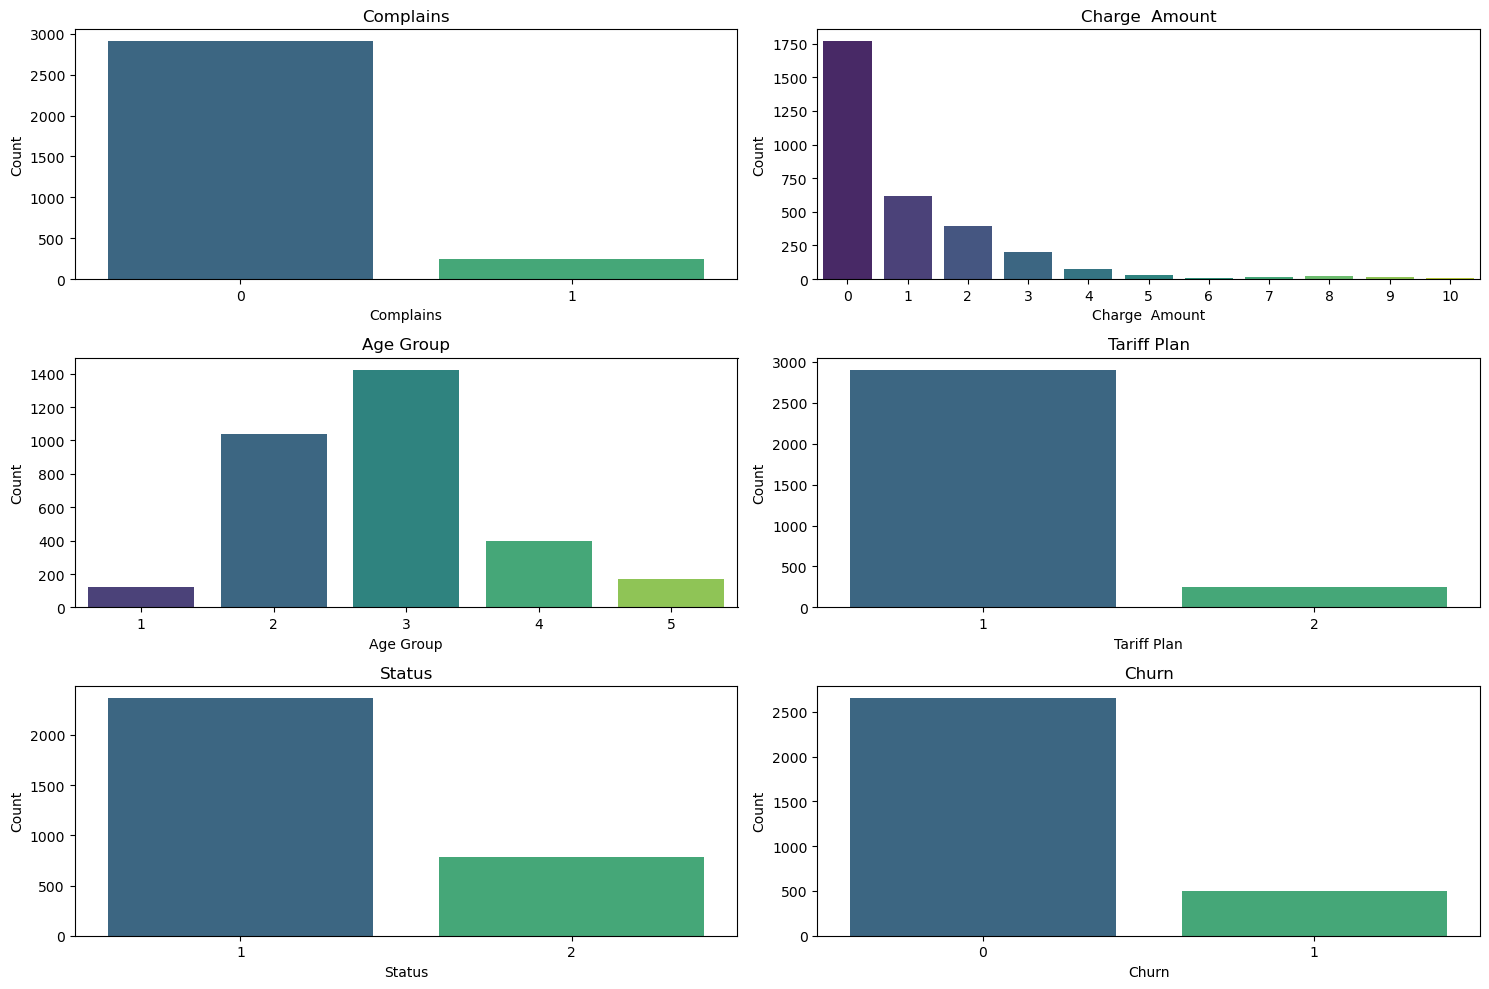

In [375]:
# Bar plots for categorical features
categorical_features = ['Complains', 'Charge  Amount', 'Age Group', 'Tariff Plan', 'Status', 'Churn']

plt.figure(figsize=(15, 10))

# Create bar plots for each categorical feature
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 2, i)
    sns.barplot(x=df[feature].value_counts().index, y=df[feature].value_counts().values, palette='viridis')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

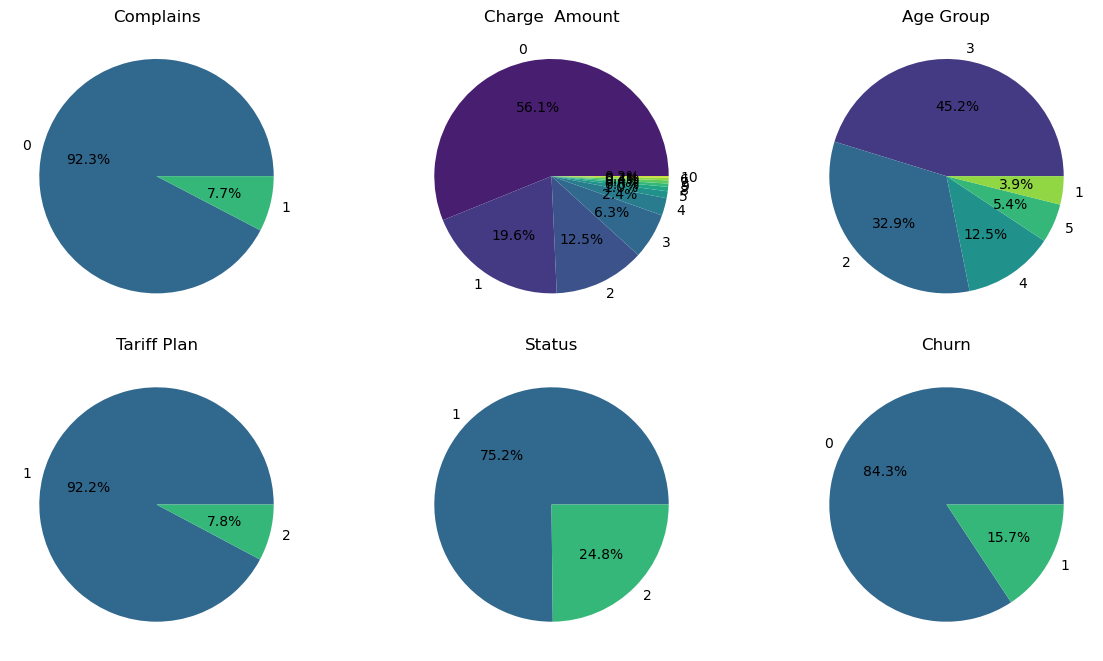

In [376]:
# Pie charts for visualizing the proportions of categorical variables
plt.figure(figsize=(12, 10))

for i, feature in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)
    plt.pie(df[feature].value_counts(), labels=df[feature].value_counts().index, autopct='%1.1f%%', 
            colors=sns.color_palette('viridis', n_colors=df[feature].nunique()))
    plt.title(feature)

plt.tight_layout()
plt.show()

#### Identify potential correlations between variables

Understanding the relationships between the raw features

     Spot features with high multicollinearity (correlation coefficients close to ±1)

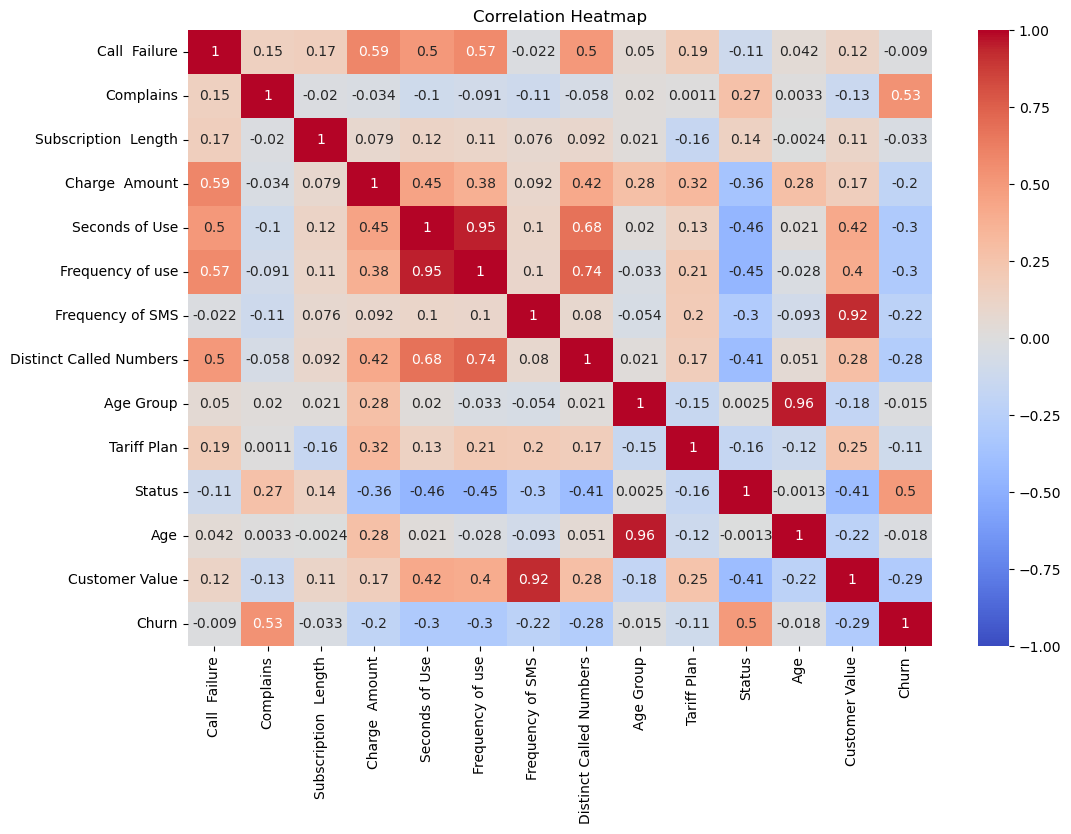

In [377]:
# Correlation heatmap to get an overall sense of how variables are correlated
# Calculate correlations
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

### Data Preprocessing

#### 1.) Handling Missing Values

In [379]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Call  Failure              0
Complains                  0
Subscription  Length       0
Charge  Amount             0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Tariff Plan                0
Status                     0
Age                        0
Customer Value             0
Churn                      0
dtype: int64


 No missing values as indicated by the output of `df.info()`

#### 2.) Feature Engineering

    Aggregation Features: aggregated statistics for related features

In [380]:
# Total Use = Seconds of Use + Frequency of use + Frequency of SMS
df['Total Use'] = df['Frequency of use'] + df['Frequency of SMS']

# Average Call Duration = Seconds of Use / Call Failure
# To avoid division by zero, replace zero Call Failures with NaN 
df['Call  Failure'] = df['Call  Failure'].replace(0, np.nan)
df['Average Call Duration'] = df['Seconds of Use'] / df['Call  Failure']
df['Call  Failure'] = df['Call  Failure'].replace(np.nan, 0)  # revert back to original value
df['Average Call Duration'] = df['Average Call Duration'].replace(np.nan, 0)

    Temporal Features

In [381]:
# Subscription duration categories: Convert Subscription Length into categorical bins

# Define bins and labels for categorization
bins = [0, 12, 24, 36, np.inf]
labels = ['short-term', 'mid-term', 'long-term', 'very-long-term']
df['Subscription Length Category'] = pd.cut(df['Subscription  Length'], bins=bins, labels=labels)

        Encode Categorical Variables

In [382]:
# Assign integers to 'Subscription Length Category'

# Ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[labels])
df['Subscription Length Category Encoded'] = ordinal_encoder.fit_transform(df[['Subscription Length Category']])

# Drop the categorical column;'Subscription Length Category' after encoding
df = df.drop(columns=['Subscription Length Category'])

    Behavioural Features
        Feature engineering to capture extreme values: Creating additional features that specifically capture the behavior of outliers.     

In [383]:
# Calculate Percentiles
percentiles = np.percentile(df['Total Use'], [75, 90, 95])
print(f'75th percentile: {percentiles[0]}')
print(f'90th percentile: {percentiles[1]}')
print(f'95th percentile: {percentiles[2]}')

# Set the Threshold
high_usage_threshold = percentiles[1]

# Is High User = 1 if Total use is above a certain threshold, otherwise 0
# Create the Is High Customer feature
df['Is High Customer'] = np.where(df['Total Use'] > high_usage_threshold, 1, 0)

75th percentile: 230.0
90th percentile: 329.0
95th percentile: 421.09999999999945


In [384]:
# Loyal Customer = 1 if Subscription Length is above a certain threshold, otherwise 0
df['Loyal Customer'] = np.where(df['Subscription Length Category Encoded'] == 3, 1, 0)

In [385]:
df

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,Churn,Total Use,Average Call Duration,Subscription Length Category Encoded,Is High Customer,Loyal Customer
0,8.0,0,38,0,4370,71,5,17,3,1,1,30,197.640,0,76,546.250000,3.0,0,1
1,0.0,0,39,0,318,5,7,4,2,1,2,25,46.035,0,12,0.000000,3.0,0,1
2,10.0,0,37,0,2453,60,359,24,3,1,1,30,1536.520,0,419,245.300000,3.0,1,1
3,10.0,0,38,0,4198,66,1,35,1,1,1,15,240.020,0,67,419.800000,3.0,0,1
4,3.0,0,38,0,2393,58,2,33,1,1,1,15,145.805,0,60,797.666667,3.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3145,21.0,0,19,2,6697,147,92,44,2,2,1,25,721.980,0,239,318.904762,1.0,0,0
3146,17.0,0,17,1,9237,177,80,42,5,1,1,55,261.210,0,257,543.352941,1.0,0,0
3147,13.0,0,18,4,3157,51,38,21,3,1,1,30,280.320,0,89,242.846154,1.0,0,0
3148,7.0,0,11,2,4695,46,222,12,3,1,1,30,1077.640,0,268,670.714286,0.0,0,0


In [386]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3150 entries, 0 to 3149
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Call  Failure                         3150 non-null   float64
 1   Complains                             3150 non-null   int64  
 2   Subscription  Length                  3150 non-null   int64  
 3   Charge  Amount                        3150 non-null   int64  
 4   Seconds of Use                        3150 non-null   int64  
 5   Frequency of use                      3150 non-null   int64  
 6   Frequency of SMS                      3150 non-null   int64  
 7   Distinct Called Numbers               3150 non-null   int64  
 8   Age Group                             3150 non-null   int64  
 9   Tariff Plan                           3150 non-null   int64  
 10  Status                                3150 non-null   int64  
 11  Age              

In [387]:
# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

Call  Failure                           0
Complains                               0
Subscription  Length                    0
Charge  Amount                          0
Seconds of Use                          0
Frequency of use                        0
Frequency of SMS                        0
Distinct Called Numbers                 0
Age Group                               0
Tariff Plan                             0
Status                                  0
Age                                     0
Customer Value                          0
Churn                                   0
Total Use                               0
Average Call Duration                   0
Subscription Length Category Encoded    0
Is High Customer                        0
Loyal Customer                          0
dtype: int64


The newly created features are also free of missing values.

#### Visualize newly created features and their distributions

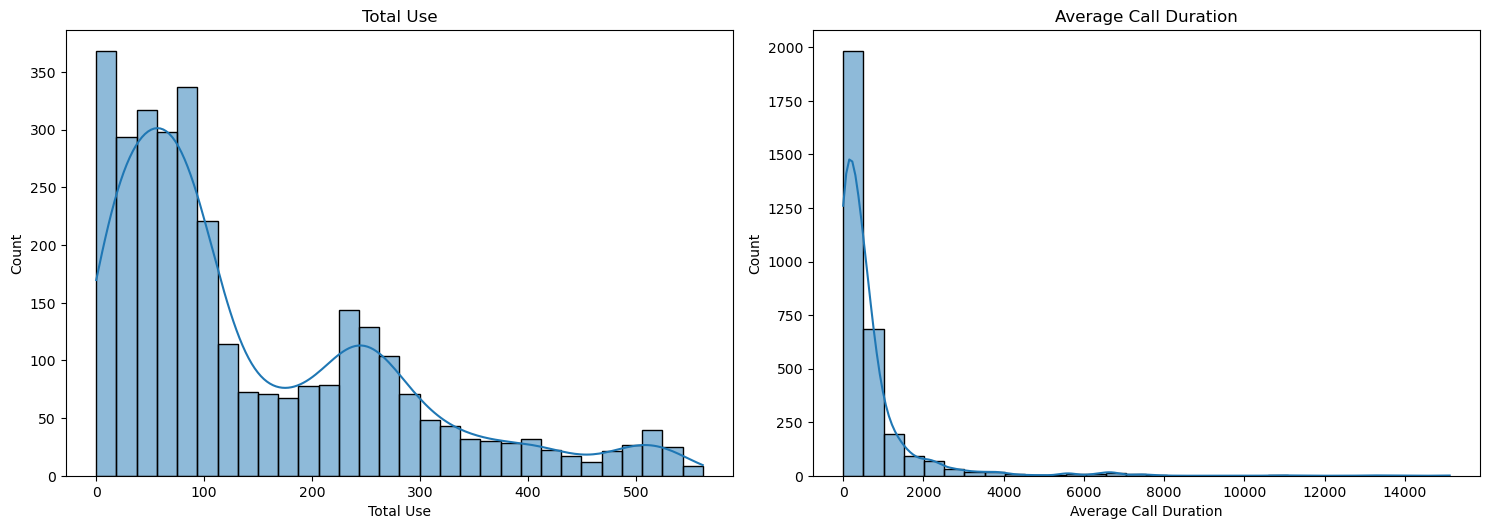

In [388]:
# Plot histograms for newly created numerical features
new_features = ['Total Use', 'Average Call Duration']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(new_features):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[feature], kde=True, bins=30, edgecolor='k')
    plt.title(feature)
plt.tight_layout()
plt.show()

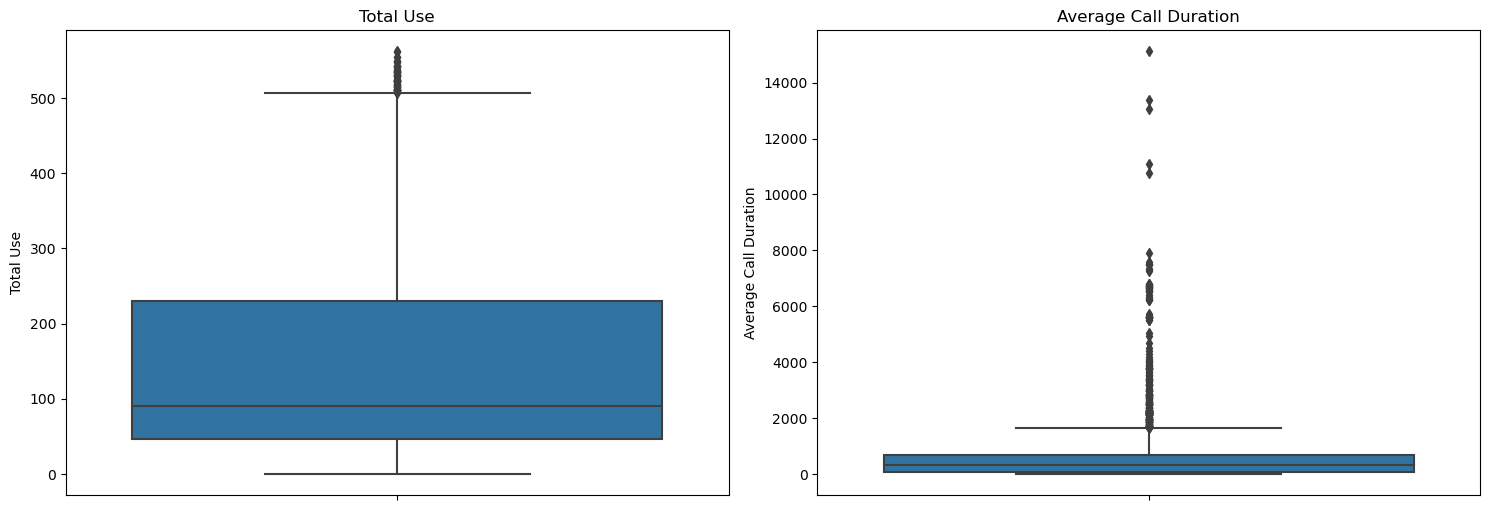

In [389]:
# Box plots to visualize distributions and outliers
plt.figure(figsize=(15, 10))
for i, feature in enumerate(new_features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=df[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

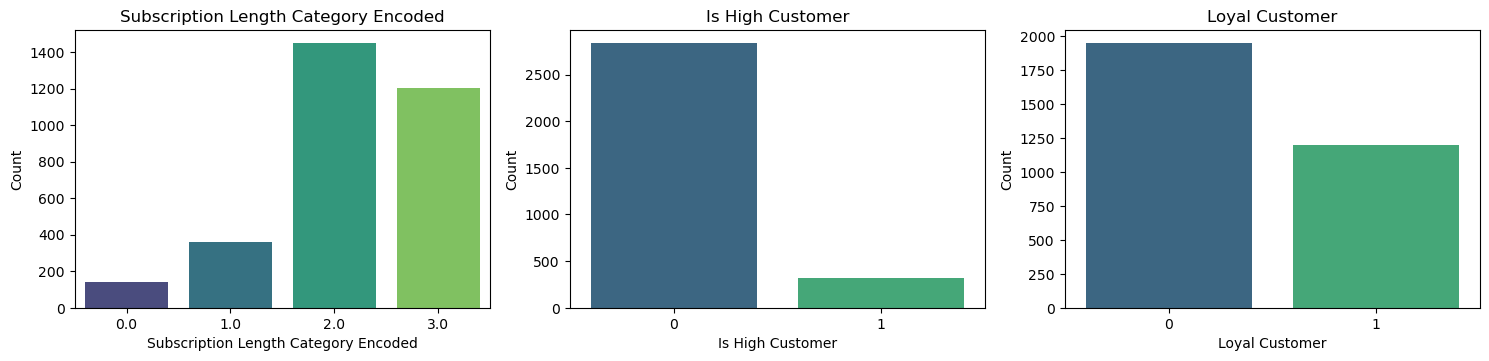

In [390]:
# Bar plots for newly created categorical features
new_categorical_features = ['Subscription Length Category Encoded', 'Is High Customer', 'Loyal Customer']

plt.figure(figsize=(15, 10))

# Create bar plots for each categorical feature
for i, feature in enumerate(new_categorical_features, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=df[feature].value_counts().index, y=df[feature].value_counts().values, palette='viridis')
    plt.title(feature)
    plt.xlabel(feature)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

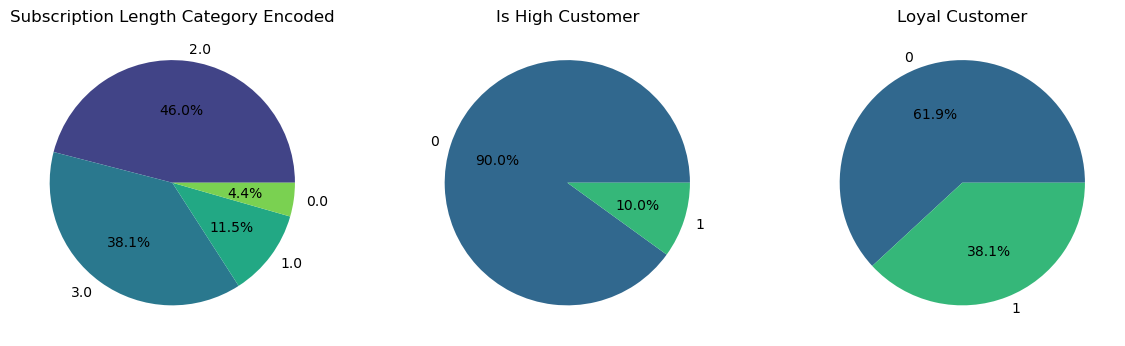

In [391]:
# Pie charts for visualizing the proportions 
plt.figure(figsize=(12, 10))

for i, feature in enumerate(new_categorical_features, 1):
    plt.subplot(3, 3, i)
    plt.pie(df[feature].value_counts(), labels=df[feature].value_counts().index, autopct='%1.1f%%', 
            colors=sns.color_palette('viridis', n_colors=df[feature].nunique()))
    plt.title(feature)

plt.tight_layout()
plt.show()

####  3.) Feature Selection

    Correlation analysis to adress multicollinearity 

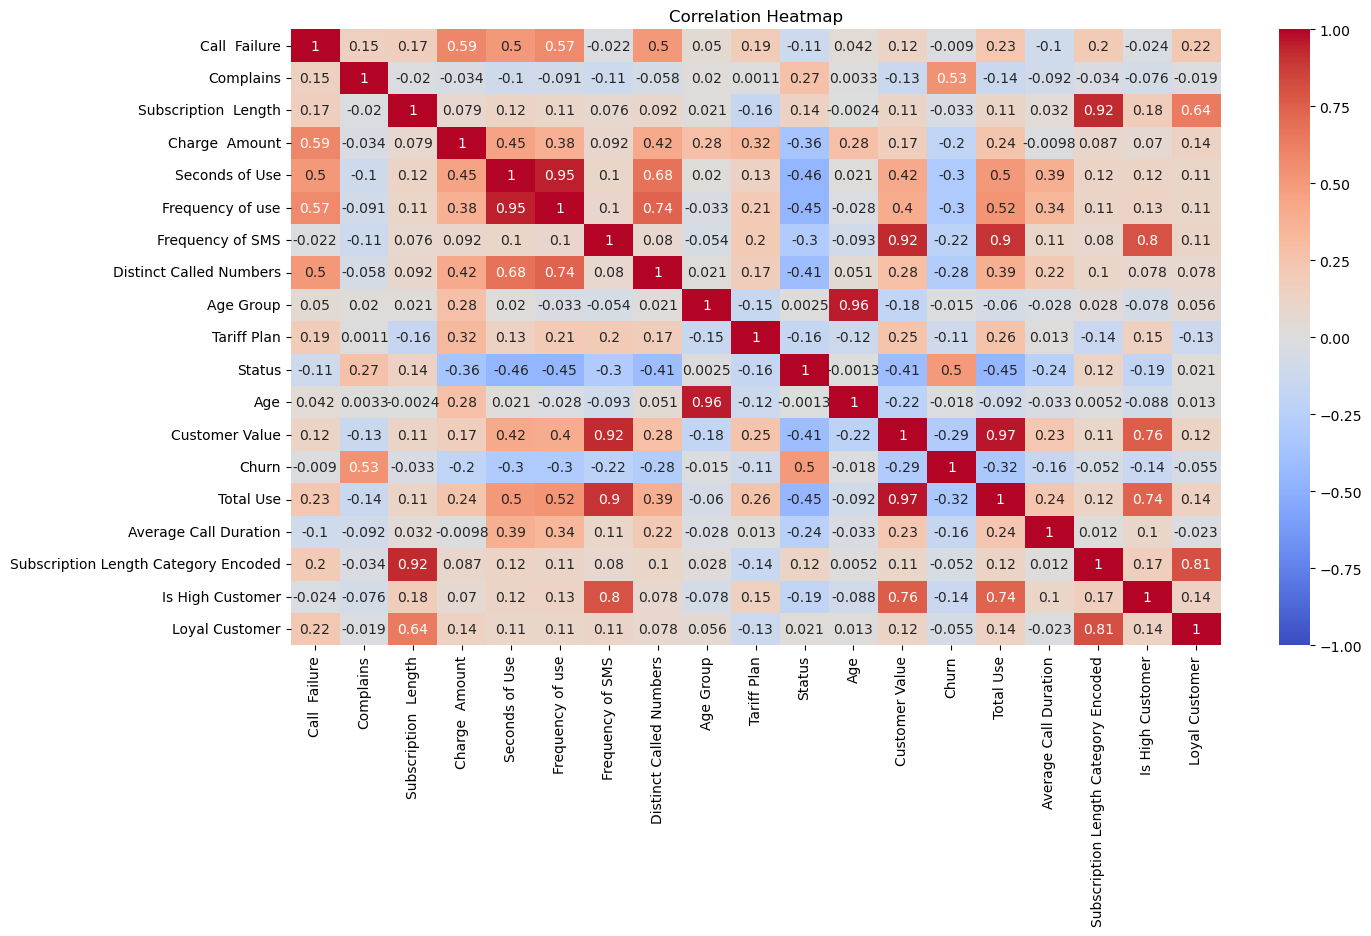

In [392]:
# Correlation heatmap to get an overall sense of how variables are correlated
# Calculate correlations
correlation_matrix = df.corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

In [393]:
# Calculate the correlation matrix
correlation_matrix = df.corr().abs()

# Identify features to drop
to_drop = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if correlation_matrix.iloc[i, j] > 0.9:  
            colname = correlation_matrix.columns[i]
            to_drop.add(colname)

# Ensure "Customer Value" and "Frequency of use" is not in the to_drop set
to_drop.discard("Customer Value")  
to_drop.discard("Frequency of use")
            
# Drop the identified features
df_reduced = df.drop(columns=to_drop)

print("Dropped columns:", to_drop)
print("Retained columns:", df_reduced.columns)

Dropped columns: {'Total Use', 'Age', 'Subscription Length Category Encoded'}
Retained columns: Index(['Call  Failure', 'Complains', 'Subscription  Length', 'Charge  Amount',
       'Seconds of Use', 'Frequency of use', 'Frequency of SMS',
       'Distinct Called Numbers', 'Age Group', 'Tariff Plan', 'Status',
       'Customer Value', 'Churn', 'Average Call Duration', 'Is High Customer',
       'Loyal Customer'],
      dtype='object')


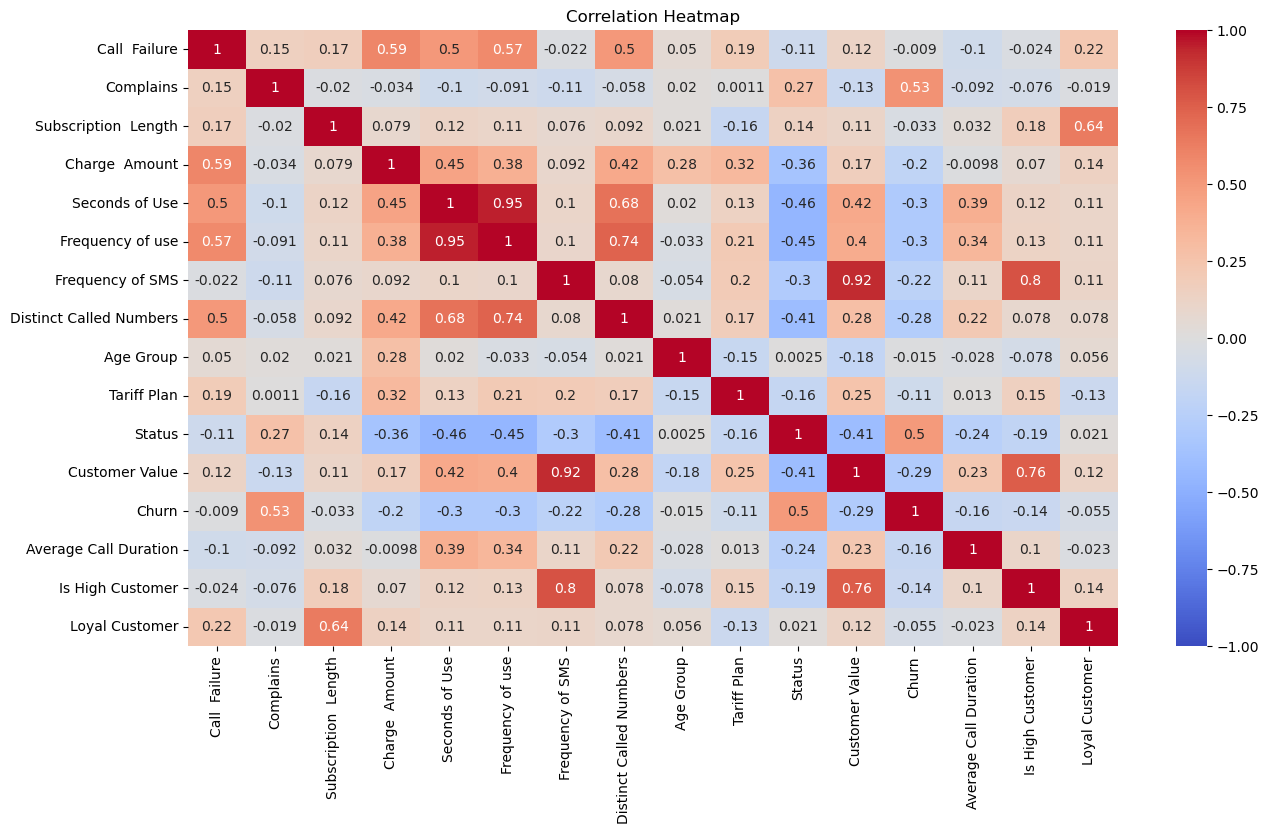

In [394]:
# Ensure multicollinearity issues are addressed
correlation_matrix = df_reduced.corr()

# Plot heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap')
plt.show()

    Feature selection 

In [395]:
# Separate the feature variables (X) and the target variable (y)
X = df_reduced.drop('Churn', axis=1)
y = df_reduced['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

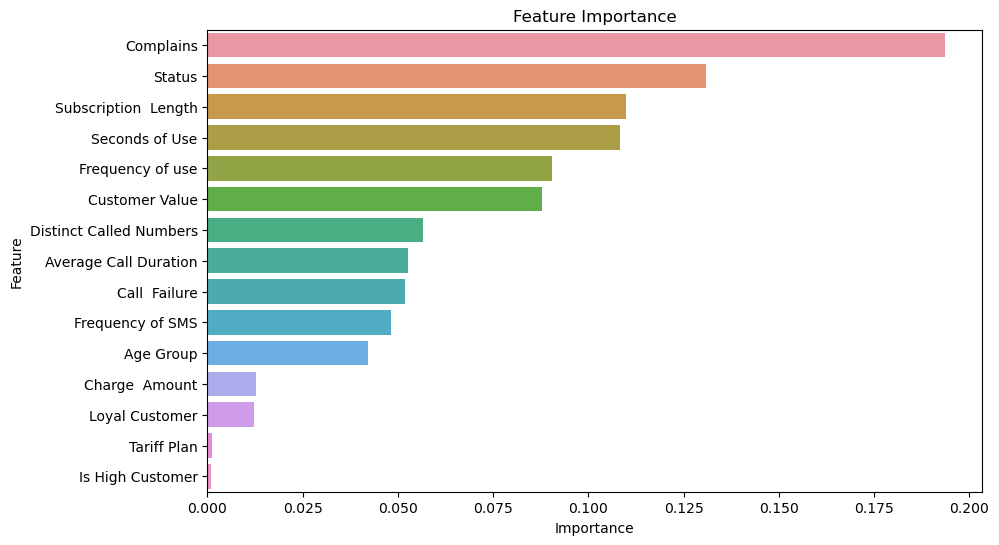

In [396]:
# Feature Importance using Random Forest
model = RandomForestClassifier()
model.fit(X_train, y_train)
importances = model.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

This chart represents the feature importance scores generated by a Random Forest model. These scores indicate the significance of each feature in predicting the target variable. Features with higher scores are deemed more important. According to this chart, the most important features are "Complains," "Seconds of Use," "Subscription Length," "Status," "Frequency of use", "Customer Value", "Distinct Called Numbers", "Call failure", "Average call duration", "Frequency of SMS" and "Age Group". These features have the highest scores, suggesting they play a crucial role in the model's predictions. On the other hand, features such as "Tariff Plan" and "Is High Customer" have the lowest scores, indicating they contribute less to the model.

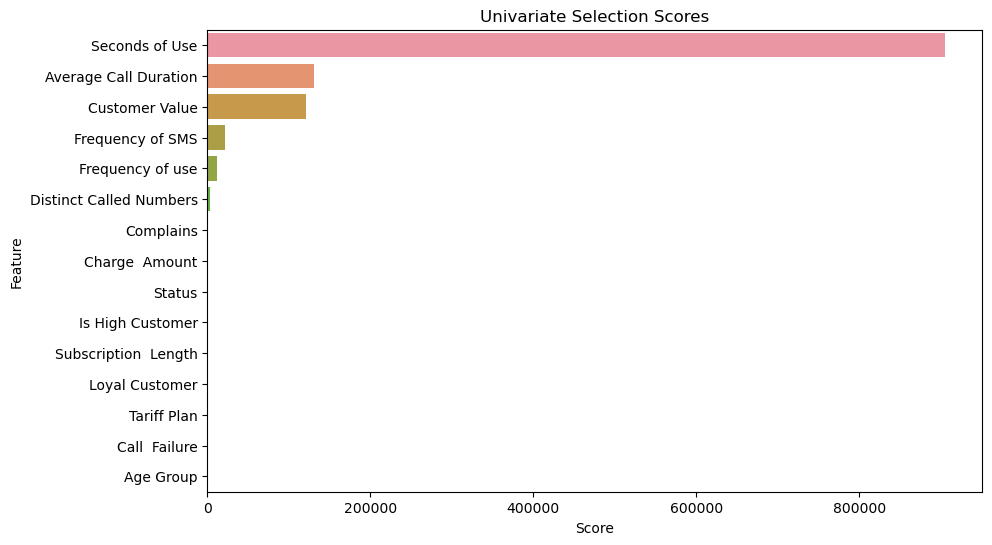

In [397]:
# Univariate Selection using SelectKBest
selector = SelectKBest(score_func=chi2, k='all')
selector.fit(X_train, y_train)
scores = selector.scores_

# Create a DataFrame for visualization
univariate_selection_df = pd.DataFrame({'Feature': X_train.columns, 'Score': scores})
univariate_selection_df = univariate_selection_df.sort_values(by='Score', ascending=False)

# Plot the univariate selection scores
plt.figure(figsize=(10, 6))
sns.barplot(x='Score', y='Feature', data=univariate_selection_df)
plt.title('Univariate Selection Scores')
plt.show()

This chart shows the univariate selection scores, which result from chi-square statistical test, measuring the relationship between each feature and the target variable. This method helps in identifying features that have a strong individual relationship with the target. "Seconds of Use" stands out with a dominantly higher score compared to other features, indicating it has a significant impact on the target variable. Other important features identified through this method include "Average Call Duration" and "Frequency of SMS." Features like "Tariff Plan," "Call Failure," and "Age Group" have low scores, suggesting a weaker relationship with the target variable.

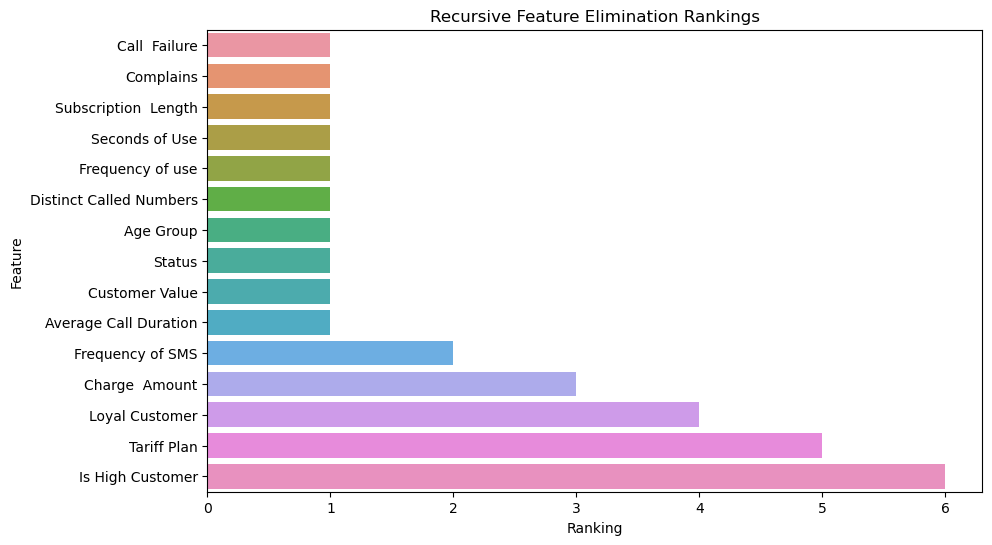

In [398]:
# Recursive Feature Elimination (RFE)
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X_train, y_train)
rfe_support = rfe.support_
rfe_ranking = rfe.ranking_

# Create a DataFrame for visualization
rfe_df = pd.DataFrame({'Feature': X_train.columns, 'Ranking': rfe_ranking})
rfe_df = rfe_df.sort_values(by='Ranking')

# Plot the RFE rankings
plt.figure(figsize=(10, 6))
sns.barplot(x='Ranking', y='Feature', data=rfe_df)
plt.title('Recursive Feature Elimination Rankings')
plt.show()

This chart depicts the results of Recursive Feature Elimination (RFE), which iteratively removes the least important feature and rebuilds the model to determine feature ranking. Features with lower ranking values are considered more important. According to this chart, the most relevant features for the model are "Call Failure," "Complains," "Subscription Length," "Seconds of Use," and "Frequency of Use." These features have the lowest rankings, indicating their high importance in predicting the target variable. On the other hand, features like "Charge Amount," "Loyal Customer," "Tariff Plan," and "Is High Customer" have higher rankings, suggesting they are less influential in the model's predictions.

Features that consistently show high importance across all three feature selection methods should be prioritized. These features include;

`"Call  Failure", "Complains", "Subscription  Length", "Seconds of Use", "Frequency of use", "Frequency of SMS",	"Distinct Called Numbers", "Age Group", "Status", "Customer Value", "Average Call Duration"`


These features have demonstrated their significance through high importance scores and favorable rankings, indicating they are most relevant features to enhance the model's predictive accuracy. Conversely, features such as "Tariff Plan" and "Is High Customer" have consistently shown low importance, suggesting they may not significantly contribute to the model and can be considered for exclusion. By focusing on the most relevant features, you can improve the efficiency and performance of your predictive model.

#### 4.) Scaling Numerical Features

    Transformations to handle skewness

In [399]:
selected_features = ["Call  Failure", "Complains", "Subscription  Length", "Seconds of Use", 
                     "Frequency of use", "Frequency of SMS", "Distinct Called Numbers", "Age Group", 
                     "Status", "Customer Value", "Average Call Duration" ]

# Check for negative values in the selected features
negative_values = X[selected_features].apply(lambda x: (x < 0).sum())
print(negative_values)

Call  Failure              0
Complains                  0
Subscription  Length       0
Seconds of Use             0
Frequency of use           0
Frequency of SMS           0
Distinct Called Numbers    0
Age Group                  0
Status                     0
Customer Value             0
Average Call Duration      0
dtype: int64


In [400]:
# Features to transform
features_to_transform = ["Call  Failure", "Subscription  Length", "Seconds of Use", 
                     "Frequency of use", "Frequency of SMS", "Distinct Called Numbers",  
                     "Customer Value", "Average Call Duration"]

# Binary variables
binary_features = ["Complains", "Age Group", "Status"]

In [401]:
# Separate the features and target variable
X = df_reduced[selected_features]
y = df_reduced['Churn']

# Apply Yeo-Johnson transformation to reduce skewness
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_transformed = pd.DataFrame(pt.fit_transform(X[features_to_transform]), columns=features_to_transform)

# Replace the transformed features in the original DataFrame
X[features_to_transform] = X_transformed

C:\Users\acer\AppData\Local\Temp\ipykernel_20068\72941446.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[features_to_transform] = X_transformed


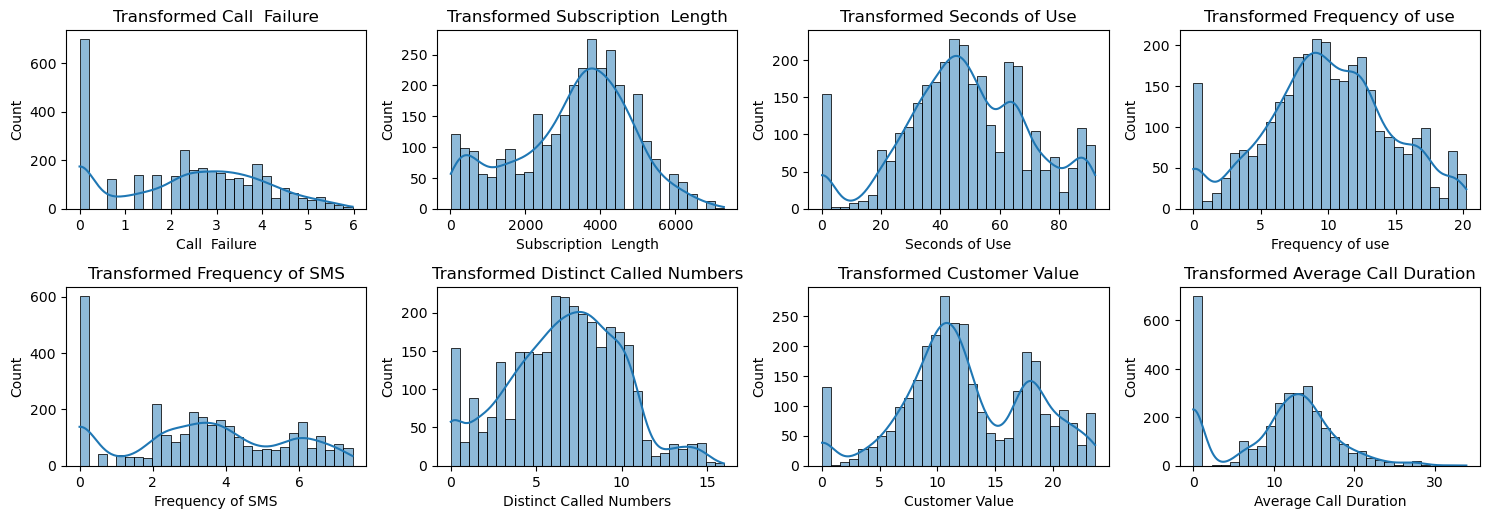

In [402]:
# Check the transformed feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(X_transformed.columns):
    plt.subplot(4, 4, i+1)
    sns.histplot(X_transformed[feature], kde=True, bins=30)
    plt.title(f'Transformed {feature}')
plt.tight_layout()
plt.show()

    Apply Robust Scaling

Given that numerical features' distributions are skewed and to retain outliers to capture extreme usage patterns or customer behaviors, using robust scaling might be the best option. It can handle outliers effectively. Robust scaling is designed to be robust to outliers by using the median and the interquartile range (IQR) for scaling, rather than the mean and standard deviation.

In [403]:
# Apply robust scaling continuous numerical features
scaler = RobustScaler()
X_scaled = X.copy()
X_scaled[features_to_transform] = scaler.fit_transform(X[features_to_transform])

In [404]:
# Combine the scaled numerical features, binary variables, and the target variable
final_df = pd.concat([X_scaled[features_to_transform], X_scaled[binary_features], y.reset_index(drop=True)], axis=1)

final_df

,Call Failure,Subscription Length,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Customer Value,Average Call Duration,Complains,Age Group,Status,Churn
0,0.149144,0.416327,0.260738,0.233831,-0.491783,-0.172487,-0.067947,0.226777,0,3,1,0
1,-0.877674,0.566620,-0.981743,-1.212483,-0.385889,-0.964035,-0.625980,-1.479002,0,2,2,0
2,0.275411,0.271847,-0.122387,0.086949,1.184287,0.118572,1.171396,-0.141857,0,3,1,0
3,0.275411,0.416327,0.231416,0.168878,-0.881175,0.498216,0.023671,0.098136,0,1,1,0
4,-0.299178,0.416327,-0.137086,0.058563,-0.740181,0.434372,-0.202514,0.425613,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3145,0.765739,-1.432376,0.600432,0.997386,0.588165,0.764350,0.638436,-0.028278,0,2,1,0
3146,0.614614,-1.529923,0.893468,1.230706,0.529767,0.707867,0.065016,0.224103,0,5,1,0
3147,0.436109,-1.483123,0.035171,-0.045631,0.228052,0.000000,0.100215,-0.146076,0,3,1,0
3148,0.078034,-1.734400,0.314199,-0.125354,0.968285,-0.420154,0.908332,0.332478,0,3,1,0


### Model Selection

    Logistic Regression for Classification Task
    Gradient Boosting Machines (GBM) for Regression Task

### Model Training and Evaluation

#### Classification - Logistic Regression

In [405]:
# Split the data into features and target variables 

# Classification task: Predicting churn
X_classification = final_df.drop('Churn', axis=1)
y_classification = final_df['Churn']

In [411]:
# Split the data into training and testing sets
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split\
(X_classification, y_classification, test_size=0.2, random_state=42)

In [422]:
# Initialize the model with class weights to address imbalance
log_reg = LogisticRegression()

# Train the model
log_reg.fit(X_train_class, y_train_class)

LogisticRegression()

In [423]:
# Predictions and Evaluation for Logistic Regression
y_pred_class = log_reg.predict(X_test_class)

# Evaluate Logistic Regression model
accuracy = accuracy_score(y_test_class, y_pred_class)
precision = precision_score(y_test_class, y_pred_class)
recall = recall_score(y_test_class, y_pred_class)
f1 = f1_score(y_test_class, y_pred_class)

print("Logistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Logistic Regression Model Evaluation:
Accuracy: 0.8698
Precision: 0.6628
Recall: 0.5182
F1 Score: 0.5816


#### Regression - Gradient Boosting Machines (GBM)

In [348]:
# Regression task: Predicting customer value
X_regression = final_df.drop('Customer Value', axis=1)
y_regression = final_df['Customer Value']

In [352]:
# Split the data into training and testing sets
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split\
(X_regression, y_regression, test_size=0.2, random_state=42)

In [356]:
# Model Training and Evaluation for Gradient Boosting Machines (GBM)
gbm = GradientBoostingRegressor()
gbm.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor()

In [357]:
# Predictions and Evaluation for GBM
y_pred_reg = gbm.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print("\nGradient Boosting Machines Model Evaluation:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")


Gradient Boosting Machines Model Evaluation:
Mean Squared Error: 0.0018
R-squared: 0.9959


### Hyperparameter Tuning

#### Logistic Regression Hyperparameter Tuning

In [359]:
log_reg = LogisticRegression()
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'solver': ['lbfgs', 'liblinear']
}
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train_class, y_train_class)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10, 100],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [360]:
# Best Logistic Regression model
best_log_reg = grid_search_lr.best_estimator_
y_pred_class_tuned = best_log_reg.predict(X_test_class)

In [361]:
# Evaluate tuned Logistic Regression
accuracy_tuned = accuracy_score(y_test_class, y_pred_class_tuned)
precision_tuned = precision_score(y_test_class, y_pred_class_tuned)
recall_tuned = recall_score(y_test_class, y_pred_class_tuned)
f1_tuned = f1_score(y_test_class, y_pred_class_tuned)

print("Tuned Logistic Regression Model Evaluation:")
print(f"After Tuning  - Accuracy: {accuracy_tuned:.4f}")
print(f"After Tuning  - Precision: {precision_tuned:.4f}")
print(f"After Tuning  - Recall: {recall_tuned:.4f}")
print(f"After Tuning  - F1 Score: {f1_tuned:.4f}")

Tuned Logistic Regression Model Evaluation:
Accuracy: 0.8730
Precision: 0.6744
Recall: 0.5273
F1 Score: 0.5918


The logistic regression model's performance is improved after hyperparameter tuning.

#### Gradient Boosting Machines Hyperparameter Tuning

In [362]:
gbm = GradientBoostingRegressor()
param_grid_gbm = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}
grid_search_gbm = GridSearchCV(gbm, param_grid_gbm, cv=5, scoring='r2')
grid_search_gbm.fit(X_train_reg, y_train_reg)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='r2')

In [363]:
# Best GBM model
best_gbm = grid_search_gbm.best_estimator_
y_pred_reg_tuned = best_gbm.predict(X_test_reg)

In [364]:
# Evaluate tuned GBM
mse_tuned = mean_squared_error(y_test_reg, y_pred_reg_tuned)
r2_tuned = r2_score(y_test_reg, y_pred_reg_tuned)

print("\nTuned Gradient Boosting Machines Model Evaluation:")
print(f"After Tuning  - Mean Squared Error: {mse_tuned:.4f}")
print(f"After Tuning  - R-squared: {r2_tuned:.4f}")


Tuned Gradient Boosting Machines Model Evaluation:
After Tuning  - Mean Squared Error: 0.0005
After Tuning  - R-squared: 0.9989


The GBM model's performance is improved after hyperparameter tuning.